# Data Sciencie Challengue

## Importe librerias

In [58]:
import requests
import pandas as pd
import numpy as np
import json
import time
import csv
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import datetime
import os
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

## Funciones

In [2]:

def get_all_category(pais):
    cats = requests.get('https://api.mercadolibre.com/sites/'+pais+'/categories')
    json_data = cats.json()
    df_cats = pd.json_normalize(json_data)
    return df_cats


def get_products_by_category(pais,category, n_fetch=1000):
    base_url = 'https://api.mercadolibre.com/sites/'+pais+'/search'
#    offset = 0
    products = []
    for offset in pam_offset:
        print(offset)
        response = requests.get(base_url, params={'category': category, 'offset': offset})
        data = response.json()
        if not data['results']:
            break
        products.extend(data['results'])

    
    return products


def get_products_detail(product_ids):
    sep = ','
    product_ids = sep.join(product_ids)
    base_url = f'https://api.mercadolibre.com/items?ids={product_ids}'
    response = requests.get(base_url).json()
    item_list = []
    for item in response:
        try:
            item_list.append(item['body'])
        except:
            continue
    return item_list

## Parametros

In [143]:
os.chdir("C:/Users/svescovij/MELI_Challenge/Data")
## Pais para analizar items 
pais = 'MLC'        
offset_ = 1000      
batch_size = 20 ##maximo de busqueda de item
# Atributos rama Json results
pam_variable = ["seller"] 


## Carga de categorias

In [34]:
cats = requests.get('https://api.mercadolibre.com/sites/'+pais+'/categories')
json_data = cats.json()
df_cats = pd.json_normalize(json_data)
pam_categoria = df_cats['id']

## Construccion de tablon Item-seller

In [144]:
# Declaro Dataframe para cosntruir Tablon
df_item = pd.DataFrame()
df_parametro = pd.DataFrame()

pam_offset = []
##

for i in range(0, offset_, 50):
    pam_offset.append(i)
pam_offset.append(offset_)
##

df_item=[]
for cat_id in pam_categoria:
    print(cat_id)
    for offset in pam_offset:
            # Busca en la api por offset y categoria
            url = f'https://api.mercadolibre.com/sites/MLC/search?category={cat_id}&offset={offset}'    
            request = requests.get(url)
            items = request.json()
            # Convierte json en Dataframe
            if not items["results"]:
                break

            df = pd.DataFrame(items["results"])
            df['cat_id']=cat_id

           
            for parametro in pam_variable:
                try:
                    # Crea un nuevo DataFrame con los datos correspondientes al parametro  
                    df_variable = pd.json_normalize(df[parametro])
                    df_variable = df_variable.add_prefix(parametro+'_')
                
                    # Concatena el nuevo DataFrame al DataFrame existente
                    df = pd.concat([df, df_variable], axis=1)
                except :
                    continue
                

            # Uno base con todos los atributos
            if len(df_item) > 0 :
                df_item= pd.concat([df_item, df], ignore_index = True)
            else:
                df_item = df



MLC1747
MLC1512
MLC1403
MLC1071
MLC1367
MLC1368
MLC1743
MLC1384
MLC1246
MLC1039
MLC1051
MLC1648
MLC1144
MLC1500
MLC1276
MLC5726
MLC1000
MLC110931
MLC178483
MLC1574
MLC1499
MLC1459
MLC1182
MLC1132
MLC3025
MLC1168
MLC3937
MLC409431
MLC1540
MLC435280
MLC1430
MLC1953


## Construccion de tablon Item-Detalle

In [147]:
product_details = []
ids_list = []
## Obtengo categorias del pais seleccionado
categories=get_all_category(pais)


## Listas de todos los productos por categoria segun parametro de offset y pais
for cat_id in categories['id']:
    print(cat_id)
    products_list = get_products_by_category(pais,cat_id, offset)
    ids_list.extend([product['id'] for product in products_list])

## obtengo detalle de todos los producto de la lista anterior
for step, _ in enumerate(range(0, len(ids_list), batch_size)):
    print(step)
    ids_to_query = ids_list[step*batch_size:batch_size*(step+1)]
    product_details.extend(get_products_detail(ids_to_query))

## Convierto en dataframe lista anterior
data = pd.DataFrame(product_details)



MLC1747
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1512
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1403
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1071
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1367
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1368
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1743
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1384
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1246
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1039
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1051
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
MLC1648
0


## Descriptivo

In [188]:
# Descriptivo Item detalle
#data.columns
data.describe()

,seller_id,official_store_id,price,base_price,original_price,initial_quantity,available_quantity,sold_quantity,health
count,3.256200e+04,4994.000000,3.189700e+04,3.189700e+04,9.824000e+03,32562.000000,32562.000000,32562.000000,19315.000000
mean,4.933745e+08,3029.877253,5.589651e+05,5.589651e+05,7.632895e+04,737.734752,85.876113,264.232940,0.820361
std,3.611625e+08,9960.108611,3.853409e+06,3.853409e+06,2.160636e+05,3381.584851,698.164529,1202.311066,0.137410
min,9.287100e+04,22.000000,1.000000e+00,1.000000e+00,7.500000e+02,0.000000,0.000000,0.000000,0.250000
25%,2.058952e+08,663.000000,7.990000e+03,7.990000e+03,8.990000e+03,19.000000,1.000000,5.000000,0.750000
50%,3.996135e+08,1168.000000,1.798000e+04,1.798000e+04,1.899400e+04,115.000000,1.000000,50.000000,0.850000
75%,6.862164e+08,1526.000000,4.274000e+04,4.274000e+04,4.826325e+04,501.000000,12.000000,250.000000,0.900000
max,1.424950e+09,54542.000000,2.089900e+08,2.089900e+08,5.999990e+06,243775.000000,50000.000000,109825.000000,1.000000


In [189]:
# Descriptivo Item seller
#df_item.columns
df_item.describe()

,order_backend,price,original_price,sold_quantity,available_quantity,official_store_id,seller_id,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.negative,...,seller_eshop.eshop_status_id,seller_eshop.eshop_experience,seller_eshop.eshop_rubro,seller_seller_reputation.metrics.claims.excluded.real_value,seller_seller_reputation.metrics.claims.excluded.real_rate,seller_seller_reputation.metrics.delayed_handling_time.excluded.real_value,seller_seller_reputation.metrics.delayed_handling_time.excluded.real_rate,seller_seller_reputation.metrics.cancellations.excluded.real_value,seller_seller_reputation.metrics.cancellations.excluded.real_rate,reservation_price
count,32607.000000,3.194200e+04,9.804000e+03,32607.000000,32607.000000,5010.000000,3.260700e+04,32607.000000,32607.000000,32607.000000,...,9377.000000,9377.000000,0.0,687.000000,687.000000,688.000000,688.000000,687.000000,687.000000,1050.0
mean,25.494035,5.597735e+05,7.649032e+04,261.361057,83.880424,3022.970259,4.933177e+08,1106.570798,27600.980556,0.098636,...,1.222672,110.553162,NaN,52.328967,0.020314,224.680233,0.082650,10.579330,0.009856,50000.0
std,14.428471,3.854147e+06,2.163745e+05,1291.508786,624.540089,9948.147751,3.612684e+08,2220.479582,54753.484968,0.118497,...,0.425191,458.628455,NaN,108.044962,0.028570,492.355237,0.109576,24.738145,0.032847,0.0
min,1.000000,1.000000e+00,7.500000e+02,0.000000,1.000000,22.000000,9.287100e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50000.0
25%,13.000000,7.990000e+03,8.990000e+03,5.000000,1.000000,663.000000,2.061858e+08,89.000000,2046.000000,0.020000,...,1.000000,0.000000,NaN,1.000000,0.005500,2.000000,0.012375,0.000000,0.000000,50000.0
50%,25.000000,1.798000e+04,1.899000e+04,50.000000,1.000000,1168.000000,3.996135e+08,368.000000,9293.000000,0.070000,...,1.000000,0.000000,NaN,6.000000,0.016800,16.000000,0.054400,2.000000,0.001500,50000.0
75%,38.000000,4.290000e+04,4.799000e+04,250.000000,50.000000,1526.000000,6.858402e+08,942.000000,24298.500000,0.130000,...,1.000000,0.000000,NaN,18.500000,0.026300,48.000000,0.108200,6.500000,0.009800,50000.0
max,50.000000,2.089900e+08,5.999990e+06,50000.000000,50000.000000,54542.000000,1.424950e+09,22413.000000,352312.000000,1.000000,...,2.000000,2019.000000,NaN,336.000000,0.333300,1517.000000,1.000000,169.000000,0.333300,50000.0


## Seleccion de variables y construccion de antiguedad

In [195]:
# Me quedo con solo la informacion de los seller
cols = [col for col in df_item.columns if col.startswith('seller_') or col == 'id' or col == 'category_id' or col == 'cat_id']
df = df_item[cols]
df_seller = df.drop_duplicates(subset=('id','category_id','cat_id','seller_id'))
cols_seller = ['id','category_id','cat_id','seller_id','seller_nickname','seller_car_dealer'
                       ,'seller_registration_date','seller_seller_reputation.level_id'
                       ,'seller_seller_reputation.power_seller_status','seller_seller_reputation.transactions.canceled'
                       ,'seller_seller_reputation.transactions.completed','seller_seller_reputation.transactions.ratings.positive'
                       ,'seller_seller_reputation.transactions.total']
df_seller2 = df_seller[cols_seller]

# selecciono columnas y quito duplicados
cols = ['id','title','seller_id','category_id','price','initial_quantity','available_quantity','sold_quantity','start_time','health']
data2 = data[cols]
data2 = data2.drop_duplicates(subset=('id','category_id','seller_id'))

## Join entre info items e info sellers
df_final = data2.merge(df_seller2, how='left', on=['id','category_id','seller_id'])

# Calculo de antiguedad item y seller
today = datetime.date.today()
df_final['start_time'] = pd.to_datetime(df_final['start_time']).dt.date
df_final['seller_registration_date'] = pd.to_datetime(df_final['seller_registration_date']).dt.date

df_final['antiguedad_item']=(today - df_final['start_time']).dt.days
df_final['antiguedad_seller']=(today - df_final['seller_registration_date']).dt.days



In [196]:
df_final.describe()

,seller_id,price,initial_quantity,available_quantity,sold_quantity,health,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.positive,seller_seller_reputation.transactions.total,antiguedad_item,antiguedad_seller
count,3.245400e+04,3.178900e+04,32454.000000,32454.000000,32454.000000,19285.000000,31999.000000,31999.000000,31999.000000,31999.000000,32454.000000,31999.000000
mean,4.931704e+08,5.607968e+05,737.948204,85.804123,264.580791,0.820303,1105.345073,27602.365574,0.783364,28707.710647,385.689561,2033.340729
std,3.612755e+08,3.859821e+06,3386.527985,698.638381,1204.290721,0.137466,2220.601830,54869.021033,0.276888,56946.269749,432.325976,1577.539828
min,9.287100e+04,1.000000e+00,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,2.000000,11.000000
25%,2.058952e+08,7.990000e+03,19.000000,1.000000,5.000000,0.750000,89.000000,2022.000000,0.780000,2142.000000,89.000000,950.000000
50%,3.996135e+08,1.798200e+04,115.000000,1.000000,50.000000,0.850000,366.000000,9277.000000,0.880000,9716.000000,226.000000,1623.000000
75%,6.862164e+08,4.290000e+04,501.000000,12.000000,250.000000,0.900000,942.000000,24291.000000,0.940000,25191.000000,529.750000,2724.000000
max,1.424950e+09,2.089900e+08,243775.000000,50000.000000,109825.000000,1.000000,22413.000000,352312.000000,1.000000,365035.000000,2764.000000,8553.000000


In [197]:
df_final.columns

Index(['id', 'title', 'seller_id', 'category_id', 'price', 'initial_quantity',
       'available_quantity', 'sold_quantity', 'start_time', 'health', 'cat_id',
       'seller_nickname', 'seller_car_dealer', 'seller_registration_date',
       'seller_seller_reputation.level_id',
       'seller_seller_reputation.power_seller_status',
       'seller_seller_reputation.transactions.canceled',
       'seller_seller_reputation.transactions.completed',
       'seller_seller_reputation.transactions.ratings.positive',
       'seller_seller_reputation.transactions.total', 'antiguedad_item',
       'antiguedad_seller', 'seg_antiguedad_seller', 'seg_antiguedad_item'],
      dtype='object')

In [221]:
#Categorias más vendidas
category_ventas = pysqldf("SELECT b.name,count(*) as cantidad_item,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado,sum(sold_quantity*price)/sum(sold_quantity) as valor_promedio  FROM df_final a left join categories b on a.cat_id=b.id group by b.name ")


category_ventas = category_ventas.sort_values('total_generado', ascending=False)
category_ventas

,name,cantidad_item,unidades_vendidas,total_generado,valor_promedio
32,Vestuario y Calzado,1041,798208,1.024300e+10,12832.490679
11,Computación,1020,337567,9.742670e+09,28861.441343
16,Electrodomésticos,1028,216614,9.664651e+09,44616.927405
21,Industrias y Oficinas,1023,940932,9.516257e+09,10113.649915
10,Celulares y Telefonía,1028,220716,9.166140e+09,41529.116412
20,Hogar y Muebles,999,483672,9.081101e+09,18775.328247
17,"Electrónica, Audio y Video",1023,330095,8.938375e+09,27078.189309
1,Accesorios para Vehículos,965,533187,8.439890e+09,15829.137622
19,Herramientas,1027,301864,7.417457e+09,24572.180426
15,Deportes y Fitness,1038,417700,7.136249e+09,17084.628295


In [267]:
# Seller
df_seller3=df_seller2.drop_duplicates(subset=('cat_id','seller_id'))
df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputation.transactions.total']

sellers_ventas = pysqldf("SELECT cat_id,seller_id,count(*) as cantidad_item,max(seg_antiguedad_seller) as seg_antiguedad_seller,max(antiguedad_seller) as antiguedad_seller,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado , avg(health) as prom_health FROM df_final   group by cat_id,seller_id ")
sellers_ventas = sellers_ventas.merge(df_seller3, how='left', on=['cat_id','seller_id'])
sellers_ventas.describe()


C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\1135687448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\1135687448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputatio

,seller_id,cantidad_item,antiguedad_seller,unidades_vendidas,total_generado,prom_health,seller_seller_reputation.transactions.canceled,seller_seller_reputation.transactions.completed,seller_seller_reputation.transactions.ratings.positive,seller_seller_reputation.transactions.total,tasa_cancelados,tasa_realizados
count,1.089000e+04,10890.000000,10562.000000,10890.000000,1.036600e+04,7420.000000,10562.000000,10562.000000,10562.000000,10562.000000,9503.000000,9503.000000
mean,5.320291e+08,2.980165,2009.058796,788.494490,1.407305e+07,0.813735,661.065518,15053.040712,0.747829,15714.106230,0.056145,0.943855
std,3.918143e+08,10.877488,1705.485490,4242.836572,8.252666e+07,0.138617,1631.283899,36295.527153,0.314520,37840.539453,0.092346,0.092346
min,9.287100e+04,1.000000,11.000000,0.000000,0.000000e+00,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.020668e+08,1.000000,772.000000,5.000000,1.943675e+05,0.750000,28.000000,620.250000,0.730000,657.250000,0.031258,0.943149
50%,4.456490e+08,1.000000,1471.000000,100.000000,1.835000e+06,0.835000,177.000000,3944.000000,0.880000,4179.000000,0.042215,0.957785
75%,7.614110e+08,2.000000,2762.750000,500.000000,8.136144e+06,0.890000,562.000000,13139.000000,0.940000,13805.000000,0.056851,0.968742
max,1.424950e+09,858.000000,8553.000000,245925.000000,5.456565e+09,1.000000,22413.000000,352312.000000,1.000000,365035.000000,1.000000,1.000000


In [268]:
## Sellers con mas dinero vendido
sellers_ventas = sellers_ventas.sort_values('total_generado', ascending=False)
sellers_ventas[['seller_nickname','seller_id','cat_id']].head(10)

,seller_nickname,seller_id,cat_id
1245,MERCADOLIBRE ELECTRONICA_CL,550063615,MLC1051
10684,SACTI,325982945,MLC5726
4562,NESTLE E-COMMERCE,445649004,MLC1403
7827,MERCADOLIBRE ELECTRONICA_CL,550063615,MLC1648
552,CAIXUN,543504573,MLC1000
9075,SBD CHILE,494183906,MLC178483
7806,HP TIENDAOFICIAL,433323657,MLC1648
4724,INDUSBORD,173175749,MLC1430
554,MERCADOLIBRE ELECTRONICA_CL,550063615,MLC1000
10760,COMERCIALIZADORALOSROBLESLT,600275643,MLC5726


In [231]:
sellers_ventas.columns

Index(['cat_id', 'seller_id', 'cantidad_item', 'seg_antiguedad_seller',
       'antiguedad_seller', 'unidades_vendidas', 'total_generado',
       'prom_health', 'id', 'category_id', 'seller_nickname',
       'seller_car_dealer', 'seller_registration_date',
       'seller_seller_reputation.level_id',
       'seller_seller_reputation.power_seller_status',
       'seller_seller_reputation.transactions.canceled',
       'seller_seller_reputation.transactions.completed',
       'seller_seller_reputation.transactions.ratings.positive',
       'seller_seller_reputation.transactions.total', 'tasa_cancelados',
       'tasa_realizados'],
      dtype='object')

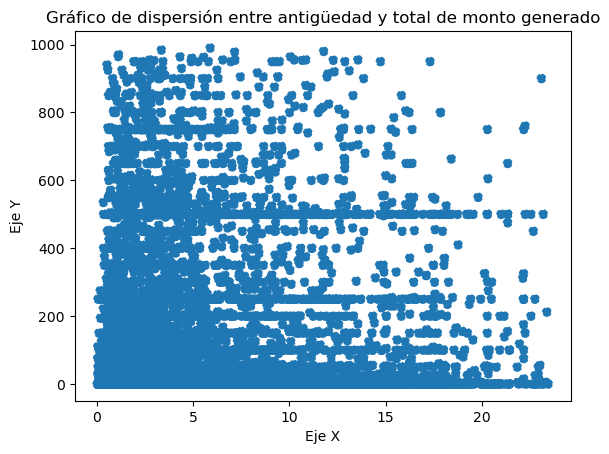

In [269]:
# Crea un gráfico de dispersión entre antiguedad y total vendido
sellers_ventas_o=sellers_ventas[sellers_ventas['unidades_vendidas'] < 1000]
plt.scatter(sellers_ventas_o['antiguedad_seller']/365, sellers_ventas_o['unidades_vendidas'], linestyle='--')

# Agrega títulos y etiquetas al gráfico
plt.title('Gráfico de dispersión entre antigüedad y total de monto generado')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Muestra el gráfico
plt.show()

## Segmento antiguedad

In [276]:
sellers_ventas['seg_antiguedad_seller'] = np.select(
    [
     (sellers_ventas['antiguedad_seller'] <360) ,
     (sellers_ventas['antiguedad_seller'] >=360) & (sellers_ventas['antiguedad_seller'] <720),
     (sellers_ventas['antiguedad_seller'] >=-720) 	& (sellers_ventas['antiguedad_seller']  < 1080),
     (sellers_ventas['antiguedad_seller'] >=1080 ) & (sellers_ventas['antiguedad_seller']  < 1440),
     (sellers_ventas['antiguedad_seller'] >=1800 ) 
    ],
    [
        '1 año',
        '2 años',
        '3 años',
        '4 años',
        '5 años'
 ],
    default='SC'
)



In [277]:

describe_seller=sellers_ventas.groupby('seg_antiguedad_seller').describe()
describe_seller.to_excel('output/sellers_ventas_describe_'+pais+'_'+str(offset)+'.xlsx')


In [265]:
sellers_ventas['RN'] = sellers_ventas.sort_values(['cat_id','seg_antiguedad_seller','total_generado'], ascending=[True,True,False]) \
             .groupby(['cat_id','seg_antiguedad_seller']) \
             .cumcount() + 1
sellers_ventas.sort_values(['cat_id','seg_antiguedad_seller'])[['cat_id','seg_antiguedad_seller','total_generado','RN']]

,cat_id,seg_antiguedad_seller,total_generado,RN
641,MLC1000,1 año <= Antiguedad < 2 años,577482090.0,1.0
648,MLC1000,1 año <= Antiguedad < 2 años,42994500.0,2.0
644,MLC1000,1 año <= Antiguedad < 2 años,42990000.0,3.0
630,MLC1000,1 año <= Antiguedad < 2 años,26542235.0,4.0
623,MLC1000,1 año <= Antiguedad < 2 años,22276725.0,5.0
...,...,...,...,...
276,None,SC,0.0,NaN
303,None,SC,0.0,NaN
306,None,SC,0.0,NaN
319,None,SC,0.0,NaN


In [150]:

###Descriptivo
#Categorias
category_ventas = pysqldf("SELECT b.name,count(*) as cantidad_item,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado  FROM df_final a left join categories b on a.cat_id=b.id group by b.name ")
#Export Excel
category_ventas.to_excel('output/category_ventas_'+pais+'_'+str(offset)+'.xlsx', index=False)
# Seller
df_seller3=df_seller2.drop_duplicates(subset=('cat_id','seller_id'))
df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputation.transactions.total']

sellers_ventas = pysqldf("SELECT cat_id,seller_id,count(*) as cantidad_item,max(seg_antiguedad_seller) as seg_antiguedad_seller,max(antiguedad_seller) as antiguedad_seller,sum(sold_quantity) as unidades_vendidas,sum(sold_quantity*price) as total_generado FROM df_final   group by cat_id,seller_id ")
sellers_ventas = sellers_ventas.merge(df_seller3, how='left', on=['cat_id','seller_id'])
#Export Excel
sellers_ventas.to_excel('output/sellers_ventas_'+pais+'_'+str(offset)+'.xlsx', index=False)

## Item
#item_ventas = pysqldf("SELECT cat_id,id,title,count(*) as cantidad ,max(seg_antiguedad_seller) as seg_antiguedad_seller,sum(sold_quantity*price) as total_generado FROM df_final   group by id,title ")
#Export Excel
#item_ventas.to_excel('output/item_ventas_'+pais+'_'+str(offset)+'.xlsx', index=False)

C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\4235796920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_cancelados']=df_seller3['seller_seller_reputation.transactions.canceled']/df_seller3[ 'seller_seller_reputation.transactions.total']
C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\4235796920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seller3['tasa_realizados']=df_seller3['seller_seller_reputation.transactions.completed']/df_seller3[ 'seller_seller_reputatio

## Segmentacion K-Means

In [159]:
#features = ['cantidad_item','antiguedad_seller','unidades_vendidas','total_generado','seller_seller_reputation.transactions.ratings.positive','tasa_cancelados','tasa_realizados']
features = ['antiguedad_seller','unidades_vendidas','total_generado']

imputer = SimpleImputer(strategy='mean')

X = imputer.fit_transform(sellers_ventas[features])
# Create the KMeans model
kmeans = KMeans(n_clusters=2)

# Fit the model to the data
kmeans.fit(X)

# Predict the cluster labels
labels = kmeans.predict(imputer.fit_transform(sellers_ventas[features]))

c:\Users\svescovij\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


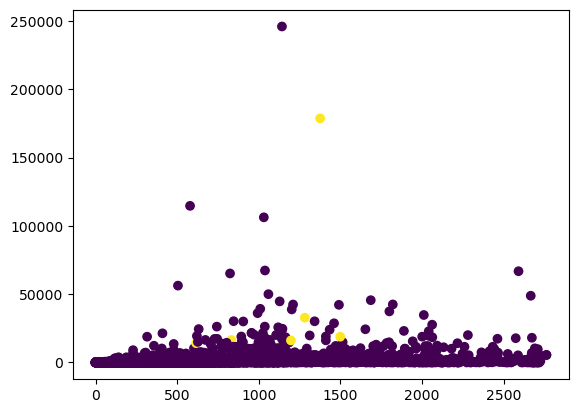

In [160]:
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()

In [78]:
sellers_ventas_k = sellers_ventas.assign(cluster=labels)
sellers_ventas_k.to_excel('output/sellers_ventas_k_'+pais+'_'+str(offset)+'.xlsx', index=False)


## Sellers por quintiles

In [133]:
## Parametro de decil, 5 quintil,10 deciles...
decil=5
atributos = ['total_generado','unidades_vendidas','seller_seller_reputation.transactions.ratings.positive','tasa_realizados']
by_seg = sellers_ventas['seg_antiguedad_seller'].unique() 
by_seg = list(by_seg)
sellers_ventas_quintil = []
sellers_ventas['total_generado'].fillna(0, inplace=True)
for k in by_seg:
    print(k)
    filtered_df = sellers_ventas[sellers_ventas['seg_antiguedad_seller'] == k]
    for i in atributos:   
        filtered_df['quintil_'+ i] = pd.qcut(filtered_df[i], decil, duplicates='drop')
    # Uno base con todos los atributos
    if len(sellers_ventas_quintil) > 0 :
        sellers_ventas_quintil= pd.concat([sellers_ventas_quintil, filtered_df], ignore_index = True)
    else:
        sellers_ventas_quintil = filtered_df

1 año <= Antiguedad < 2 años
3 meses <= Antiguedad < 1 año
Antiguedad <3 meses
2 años <= Antiguedad 


C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\2801299724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['quintil_'+ i] = pd.qcut(filtered_df[i], decil, duplicates='drop')
C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\2801299724.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['quintil_'+ i] = pd.qcut(filtered_df[i], decil, duplicates='drop')
C:\Users\svescovij\AppData\Local\Temp\ipykernel_47000\2801299724.py:12: SettingWithCopyWarning: 
A value is trying to 

In [131]:
sellers_ventas_quintil.count()
sellers_ventas_quintil.to_excel('output/sellers_ventas_quintil_'+pais+'_'+str(offset)+'.xlsx', index=False)
